In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

In [2]:
from typing import List, Set, Dict, Tuple, Optional, Any
from collections import defaultdict

import pandas as pd
import seaborn as sns
import numpy as np

import math 
import torch
from torch import nn, Tensor
from torch.nn.functional import softplus, relu
from torch.distributions import Distribution, Normal
from torch.utils.data import DataLoader, Dataset

from gmfpp.utils.data_preparation import *
from gmfpp.utils.data_transformers import *
from gmfpp.utils.plotting import *
from gmfpp.utils.training import *

from gmfpp.models.ReparameterizedDiagonalGaussian import *
from gmfpp.models.CytoVariationalAutoencoder import *
from gmfpp.models.VariationalAutoencoder import *
from gmfpp.models.ConvVariationalAutoencoder import *
from gmfpp.models.VariationalInference import *
from gmfpp.models.LoadModels import *

In [3]:
constant_seed()

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


# Load Data

In [5]:
# here Andrea had to modify the "all" folder with "small", because there is no "all" folder in the repository
#metadata_all = read_metadata("./data/all/metadata.csv")
#metadata_all = read_metadata("./data/small/metadata.csv")
#metadata_all = read_metadata("./data/two_from_each_well/metadata.csv")
metadata_all = read_metadata("./data/mix_from_all/metadata.csv")
metadata_all = shuffle_metadata(metadata_all)

In [34]:
read_metadata("./data/mix_from_all/metadata.csv")

,Unnamed: 0,Multi_Cell_Image_Id,Multi_Cell_Image_Name,Single_Cell_Image_Id,Single_Cell_Image_Name,TableNumber,ImageNumber,Image_FileName_DAPI,Image_PathName_DAPI,Image_FileName_Tubulin,Image_PathName_Tubulin,Image_FileName_Actin,Image_PathName_Actin,Image_Metadata_Plate_DAPI,Image_Metadata_Well_DAPI,Replicate,Image_Metadata_Compound,Image_Metadata_Concentration,moa
0,0,433,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,0,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,0,1,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,Week10_40111,Week10_200907_B02_s1_w2D492FCE4-15C2-4C66-99A5...,Week10_40111,Week10_200907_B02_s1_w436D0A3BC-098D-4271-B5AA...,Week10_40111,Week10_40111,B02,1,DMSO,0.000,DMSO
1,1,433,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,1,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,0,1,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,Week10_40111,Week10_200907_B02_s1_w2D492FCE4-15C2-4C66-99A5...,Week10_40111,Week10_200907_B02_s1_w436D0A3BC-098D-4271-B5AA...,Week10_40111,Week10_40111,B02,1,DMSO,0.000,DMSO
2,2,433,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,2,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,0,1,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,Week10_40111,Week10_200907_B02_s1_w2D492FCE4-15C2-4C66-99A5...,Week10_40111,Week10_200907_B02_s1_w436D0A3BC-098D-4271-B5AA...,Week10_40111,Week10_40111,B02,1,DMSO,0.000,DMSO
3,3,433,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,3,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,0,1,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,Week10_40111,Week10_200907_B02_s1_w2D492FCE4-15C2-4C66-99A5...,Week10_40111,Week10_200907_B02_s1_w436D0A3BC-098D-4271-B5AA...,Week10_40111,Week10_40111,B02,1,DMSO,0.000,DMSO
4,4,433,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,4,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,0,1,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,Week10_40111,Week10_200907_B02_s1_w2D492FCE4-15C2-4C66-99A5...,Week10_40111,Week10_200907_B02_s1_w436D0A3BC-098D-4271-B5AA...,Week10_40111,Week10_40111,B02,1,DMSO,0.000,DMSO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1145,477147,3759,Week9_090907_F10_s1_w1A2464F17-6D7B-459B-8EA3-...,5,Week9_090907_F10_s1_w1A2464F17-6D7B-459B-8EA3-...,9,3073,Week9_090907_F10_s1_w1A2464F17-6D7B-459B-8EA3-...,Week9_39282,Week9_090907_F10_s1_w2092092EB-F7FB-4A14-AF8C-...,Week9_39282,Week9_090907_F10_s1_w4927E51CD-B238-4B7D-8946-...,Week9_39282,Week9_39282,F10,1,mitoxantrone,0.003,DNA replication
1146,477148,3759,Week9_090907_F10_s1_w1A2464F17-6D7B-459B-8EA3-...,6,Week9_090907_F10_s1_w1A2464F17-6D7B-459B-8EA3-...,9,3073,Week9_090907_F10_s1_w1A2464F17-6D7B-459B-8EA3-...,Week9_39282,Week9_090907_F10_s1_w2092092EB-F7FB-4A14-AF8C-...,Week9_39282,Week9_090907_F10_s1_w4927E51CD-B238-4B7D-8946-...,Week9_39282,Week9_39282,F10,1,mitoxantrone,0.003,DNA replication
1147,477149,3759,Week9_090907_F10_s1_w1A2464F17-6D7B-459B-8EA3-...,7,Week9_090907_F10_s1_w1A2464F17-6D7B-459B-8EA3-...,9,3073,Week9_090907_F10_s1_w1A2464F17-6D7B-459B-8EA3-...,Week9_39282,Week9_090907_F10_s1_w2092092EB-F7FB-4A14-AF8C-...,Week9_39282,Week9_090907_F10_s1_w4927E51CD-B238-4B7D-8946-...,Week9_39282,Week9_39282,F10,1,mitoxantrone,0.003,DNA replication
1148,477150,3759,Week9_090907_F10_s1_w1A2464F17-6D7B-459B-8EA3-...,8,Week9_090907_F10_s1_w1A2464F17-6D7B-459B-8EA3-...,9,3073,Week9_090907_F10_s1_w1A2464F17-6D7B-459B-8EA3-...,Week9_39282,Week9_090907_F10_s1_w2092092EB-F7FB-4A14-AF8C-...,Week9_39282,Week9_090907_F10_s1_w4927E51CD-B238-4B7D-8946-...,Week9_39282,Week9_39282,F10,1,mitoxantrone,0.003,DNA replication


In [6]:
metadata = metadata_all[:2000]
metadata['Well_unique'] = metadata['Image_Metadata_Well_DAPI'] + '_' + metadata['Image_Metadata_Plate_DAPI']
metadata['Treatment'] = metadata['Image_Metadata_Compound'] + '_' + metadata['Image_Metadata_Concentration'].astype(str)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
metadata = shuffle_metadata(metadata)
metadata_train, metadata_validation = split_metadata(metadata, split_fraction = .90)

In [8]:
# same problem as with the dataset as above -- change this back to "all" iff needed

relative_path = get_relative_image_paths(metadata)
#image_paths = ["./data/all/" + path for path in relative_path]
#image_paths = ["./data/small/" + path for path in relative_path]
#image_paths = ["./data/two_from_each_well/" + path for path in relative_path]
image_paths = ["./data/mix_from_all/" + path for path in relative_path]

In [9]:
images = load_images(image_paths, verbose=True, log_every=10000)

19:36:21 | loaded 0/1150 images (0.00%).
19:37:00 | loaded 1150/1150 images (100.00%).


# Normalize Data

In [10]:
normalize_every_image_channels_seperately_inplace(images)
#normalize_channels_inplace(images)

In [11]:
channel_first = view_channel_dim_first(images)
for i in range(channel_first.shape[0]):
    channel = channel_first[i]
    print("channel {} interval: [{:.2f}; {:.2f}]".format(i, torch.min(channel), torch.max(channel)))

channel 0 interval: [0.02; 1.00]
channel 1 interval: [0.01; 1.00]
channel 2 interval: [0.01; 1.00]


# VAE

In [12]:
# VAE
image_shape = np.array([3, 68, 68])
latent_features = 256
vae = CytoVariationalAutoencoder(image_shape, latent_features).to(device) # @TODO: load trained parameters - see below

# load trained parameters
vae, validation_data, training_data, VAE_settings = LoadVAEmodel("pretrained", '2022-11-25 - 20-36-12')

# Finding Targe Cells for each Well and Compound/Concentration

In [13]:
images.shape[0]
batch_size=4

batch_offset = np.arange(start=0, stop=images.shape[0]+1, step=batch_size)
print(batch_offset)

[   0    4    8   12   16   20   24   28   32   36   40   44   48   52
   56   60   64   68   72   76   80   84   88   92   96  100  104  108
  112  116  120  124  128  132  136  140  144  148  152  156  160  164
  168  172  176  180  184  188  192  196  200  204  208  212  216  220
  224  228  232  236  240  244  248  252  256  260  264  268  272  276
  280  284  288  292  296  300  304  308  312  316  320  324  328  332
  336  340  344  348  352  356  360  364  368  372  376  380  384  388
  392  396  400  404  408  412  416  420  424  428  432  436  440  444
  448  452  456  460  464  468  472  476  480  484  488  492  496  500
  504  508  512  516  520  524  528  532  536  540  544  548  552  556
  560  564  568  572  576  580  584  588  592  596  600  604  608  612
  616  620  624  628  632  636  640  644  648  652  656  660  664  668
  672  676  680  684  688  692  696  700  704  708  712  716  720  724
  728  732  736  740  744  748  752  756  760  764  768  772  776  780
  784 

In [14]:
# extracting latent variables for each image/cell

def z_extraction(metadata, images, batch_size, vae):
  images.shape[0]
  batch_size=batch_size
  batch_offset = np.arange(start=0, stop=images.shape[0]+1, step=batch_size)

  df = pd.DataFrame()
  new_metadata = pd.DataFrame()

  for j, item in enumerate(batch_offset[:-1]):
      start = batch_offset[j]
      end = batch_offset[j+1]

      outputs = vae(images[start:end,:,:,:])
      z = outputs["z"]
      z_df = pd.DataFrame(z.detach().numpy())
      z_df.index = list(range(start,end))
      df = pd.concat([metadata.iloc[start:end], z_df], axis=1)
      new_metadata = pd.concat([new_metadata, df], axis=0)

  return new_metadata

In [15]:
nm = z_extraction(metadata, images, batch_size, vae)
nm

,Unnamed: 0,Multi_Cell_Image_Id,Multi_Cell_Image_Name,Single_Cell_Image_Id,Single_Cell_Image_Name,TableNumber,ImageNumber,Image_FileName_DAPI,Image_PathName_DAPI,Image_FileName_Tubulin,...,246,247,248,249,250,251,252,253,254,255
0,252112,375,G05_s1_w1EEDF0712-3112-4798-9254-788374B3EBD9,5,G05_s1_w1EEDF0712-3112-4798-9254-788374B3EBD9_...,4,3093,G05_s1_w1EEDF0712-3112-4798-9254-788374B3EBD9.tif,Week4_27801,G05_s1_w2A57BFC48-7BA3-43D1-9454-4221E458BD66.tif,...,1.710681,-3.405804,-3.985713,3.628738,0.086376,0.269028,-0.414974,2.483156,2.900129,2.757358
1,74895,721,Week1_150607_B05_s1_w12F4AB0D9-2FD7-4563-BF1D-...,4,Week1_150607_B05_s1_w12F4AB0D9-2FD7-4563-BF1D-...,1,2893,Week1_150607_B05_s1_w12F4AB0D9-2FD7-4563-BF1D-...,Week1_22361,Week1_150607_B05_s1_w2529E219F-9E07-4735-9206-...,...,-2.987455,1.409883,-0.083221,-0.817735,2.238451,-4.588113,2.337346,-0.314419,-4.823447,1.460214
2,141330,1613,Week3_290607_B05_s1_w1B12F5390-FE04-4013-BEE2-...,0,Week3_290607_B05_s1_w1B12F5390-FE04-4013-BEE2-...,3,13,Week3_290607_B05_s1_w1B12F5390-FE04-4013-BEE2-...,Week3_25421,Week3_290607_B05_s1_w2B57FE6C1-75D7-4B0F-901A-...,...,2.414869,-0.171636,-3.995393,3.888929,2.272825,2.030403,3.942008,-5.922760,3.553857,-2.744163
3,3441,471,Week10_200907_C05_s1_w1CCD0C22C-717E-4F62-8FF2...,6,Week10_200907_C05_s1_w1CCD0C22C-717E-4F62-8FF2...,0,53,Week10_200907_C05_s1_w1CCD0C22C-717E-4F62-8FF2...,Week10_40111,Week10_200907_C05_s1_w2DE115BC3-BC1E-4303-8219...,...,-0.641278,3.754029,2.287447,-3.682684,-2.764186,-0.506040,-4.550258,2.500869,-2.233270,-3.043130
4,13277,627,Week10_200907_F02_s1_w1DF5FDA94-5FCF-41B3-9656...,2,Week10_200907_F02_s1_w1DF5FDA94-5FCF-41B3-9656...,0,161,Week10_200907_F02_s1_w1DF5FDA94-5FCF-41B3-9656...,Week10_40111,Week10_200907_F02_s1_w26D7A740E-66D3-47CC-BEB1...,...,3.919448,2.927941,4.166117,-4.497015,3.456796,0.767842,4.958160,0.618127,-2.188950,-1.793081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1143,4805,505,Week10_200907_C08_s1_w14962D4AB-2A48-4B3B-BBE1...,6,Week10_200907_C08_s1_w14962D4AB-2A48-4B3B-BBE1...,0,65,Week10_200907_C08_s1_w14962D4AB-2A48-4B3B-BBE1...,Week10_40111,Week10_200907_C08_s1_w2F9EB49AC-DE29-415C-A7A0...,...,-2.885714,-0.737390,2.667868,0.656025,-5.110986,0.824040,-2.869857,-0.329856,-4.926680,2.237576
1144,405644,3078,Week7_7__F04_s1_w1D8760743-4E7A-405F-8F24-C134...,7,Week7_7__F04_s1_w1D8760743-4E7A-405F-8F24-C134...,7,3049,Week7_7__F04_s1_w1D8760743-4E7A-405F-8F24-C134...,Week7_34661,Week7_7__F04_s1_w2500B0AA3-AAFB-4356-8C4E-34E4...,...,-0.018181,-2.274724,4.390459,-0.410926,0.215004,-2.517410,-4.201649,0.747309,-3.964204,2.449304
1145,6300,542,Week10_200907_D02_s1_w1E8853E7D-940A-46CA-A42C...,4,Week10_200907_D02_s1_w1E8853E7D-940A-46CA-A42C...,0,81,Week10_200907_D02_s1_w1E8853E7D-940A-46CA-A42C...,Week10_40111,Week10_200907_D02_s1_w2C6B52338-5CD2-4434-8398...,...,-2.106383,3.848512,-1.840647,3.920534,-0.208488,5.649556,-1.303567,3.660558,2.308335,-4.395069
1146,252107,375,G05_s1_w1EEDF0712-3112-4798-9254-788374B3EBD9,0,G05_s1_w1EEDF0712-3112-4798-9254-788374B3EBD9_...,4,3093,G05_s1_w1EEDF0712-3112-4798-9254-788374B3EBD9.tif,Week4_27801,G05_s1_w2A57BFC48-7BA3-43D1-9454-4221E458BD66.tif,...,5.228197,0.922124,-1.052521,-2.091652,-3.856126,-3.613803,2.957520,-4.654444,2.619969,0.196059


In [16]:
# Wells unique Profiles
def well_profiles(nm):
  wa = nm.groupby('Well_unique').mean().iloc[:,-256:]
  return wa

wa = well_profiles(nm)
wa

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
Well_unique,,,,,,,,,,,,,,,,,,,,,
B02_Week10_40111,2.197969,1.847700,1.075443,-0.755408,0.013666,-0.671360,-0.226263,1.732998,-1.505796,-1.051048,...,-0.879821,-0.773964,0.337882,-0.654532,-0.615450,0.176297,-2.290390,-0.964481,-1.508680,1.189335
B03_Week1_22123,1.060319,-0.391708,-0.586377,1.346731,-0.025868,-2.321539,0.088946,1.867217,1.071724,0.849639,...,1.111718,-0.381199,-0.574446,0.347747,1.816289,0.067389,-1.168889,1.197898,-1.066712,-0.257861
B03_Week3_25681,1.051383,0.321180,-0.080015,-0.380681,-0.221687,0.473747,-0.319549,1.662001,-1.040207,-0.373976,...,1.567794,0.410582,-0.448148,2.273626,1.554510,-0.323444,0.937515,0.320027,-0.904789,0.081176
B03_Week4_27801,-0.392997,0.287189,0.213178,-0.616697,0.120709,-1.797395,-1.424105,0.634168,1.448444,-0.721821,...,2.668468,1.232505,-0.677847,-1.397142,-0.993216,-0.755024,-0.147771,-0.692706,0.548318,-0.316866
B03_Week5_28901,-1.156757,0.151332,-0.264226,0.739500,0.717069,-1.659035,-0.774878,0.156586,-0.737869,-1.941326,...,-0.669214,-1.078223,0.464618,2.039950,1.066275,-1.096841,0.452168,-0.960138,1.144670,-0.694279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
G06_Week7_34661,-0.305638,0.957886,-1.949091,1.813799,-1.077842,-0.314668,1.345765,-0.699155,-0.384626,-1.180195,...,-0.667857,-0.296556,0.630265,0.897730,-1.096736,-0.540778,-0.748803,-2.029655,0.571844,0.345683
G07_Week1_22123,-0.096073,-0.338399,-0.858170,-1.461818,-1.135729,-1.064696,0.246087,0.246302,-2.007510,-0.886870,...,-0.826771,-0.198917,0.468709,0.072826,0.664016,-0.589352,-0.288451,0.743769,0.402293,0.635259
G07_Week4_27801,1.439985,1.212195,-1.799884,0.170906,-1.277713,2.863594,0.770487,0.234427,2.166897,1.518069,...,1.903281,-0.523672,-0.613693,0.937709,-0.094686,0.835362,-1.218720,-3.204604,2.646514,-0.033800


In [67]:
# function to get the cell closest to each Well profile

def well_center_cells(df,well_profiles,p=2):
  wcc = []
  for w in well_profiles.index:
    diffs = (abs(df[df['Well_unique'] == w].iloc[:,-256:] - well_profiles.loc[w])**p)
    diffs_sum = diffs.sum(axis=1)**(1/p)
    diffs_min = diffs_sum.min()
    wcc.append(diffs[diffs_sum == diffs_min].index[0])
    
  #return wcc
  return df.loc[wcc]

well_center_cells(nm,wa,p=2)

,Unnamed: 0,Multi_Cell_Image_Id,Multi_Cell_Image_Name,Single_Cell_Image_Id,Single_Cell_Image_Name,TableNumber,ImageNumber,Image_FileName_DAPI,Image_PathName_DAPI,Image_FileName_Tubulin,...,246,247,248,249,250,251,252,253,254,255
461,0,433,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,0,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,0,1,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,Week10_40111,Week10_200907_B02_s1_w2D492FCE4-15C2-4C66-99A5...,...,-2.459466,0.558561,2.508555,-5.243906,-1.904196,0.024277,-4.221147,-1.554251,-1.002840,3.008637
641,43824,697,Week1_150607_B03_s1_w114129FBE-AB04-4F79-B8AF-...,8,Week1_150607_B03_s1_w114129FBE-AB04-4F79-B8AF-...,1,5,Week1_150607_B03_s1_w114129FBE-AB04-4F79-B8AF-...,Week1_22123,Week1_150607_B03_s1_w2CAEC09A2-969B-48A9-BE0B-...,...,-2.029892,0.358778,-0.508928,-3.499818,3.282493,-2.989119,-3.128386,1.831846,-0.633381,-2.749737
842,188171,1573,Week3_290607_B03_s1_w100C7CD1E-0BA4-464E-B6CA-...,4,Week3_290607_B03_s1_w100C7CD1E-0BA4-464E-B6CA-...,3,2885,Week3_290607_B03_s1_w100C7CD1E-0BA4-464E-B6CA-...,Week3_25681,Week3_290607_B03_s1_w29AC06656-36E8-4DE8-A47C-...,...,4.610961,0.878016,-1.381977,1.894165,5.589386,-0.213312,-4.626963,-4.238053,-4.512220,-1.146166
653,243431,25,B03_s1_w1245F53B5-B09F-48CE-924F-1D937FE36570,8,B03_s1_w1245F53B5-B09F-48CE-924F-1D937FE36570_...,4,2885,B03_s1_w1245F53B5-B09F-48CE-924F-1D937FE36570.tif,Week4_27801,B03_s1_w2AC794C95-91E6-46D6-8738-44409D26D3D0.tif,...,7.116889,-3.461833,-5.309129,-0.382689,-3.504562,-5.989621,2.826133,-3.212196,0.626260,-1.632177
988,279067,2210,Week5_130707_B03_s1_w12F605B4A-ABEB-4C0B-BC2E-...,1,Week5_130707_B03_s1_w12F605B4A-ABEB-4C0B-BC2E-...,5,5,Week5_130707_B03_s1_w12F605B4A-ABEB-4C0B-BC2E-...,Week5_28901,Week5_130707_B03_s1_w292A74759-E4B0-4790-B984-...,...,1.479453,4.064829,-2.810259,1.006969,1.019615,-0.347923,1.106129,3.705362,3.950057,3.642096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997,411431,3126,Week7_7__G06_s1_w1A8FE19DE-EBF1-4C36-8829-C285...,0,Week7_7__G06_s1_w1A8FE19DE-EBF1-4C36-8829-C285...,7,3097,Week7_7__G06_s1_w1A8FE19DE-EBF1-4C36-8829-C285...,Week7_34661,Week7_7__G06_s1_w2277D6362-F535-4AFD-BC8A-CB06...,...,-3.217000,1.958684,-1.704427,2.495854,1.415023,1.186707,-5.110588,-3.997195,-2.317068,-0.375894
873,51235,1141,Week1_150607_G07_s1_w1104BC9E3-2271-47EB-AE8C-...,5,Week1_150607_G07_s1_w1104BC9E3-2271-47EB-AE8C-...,1,221,Week1_150607_G07_s1_w1104BC9E3-2271-47EB-AE8C-...,Week1_22123,Week1_150607_G07_s1_w29EBD2B89-AA5E-4C19-BE37-...,...,-3.247806,-0.370438,-3.119680,3.825804,2.475365,-3.127439,0.751538,-5.184025,-3.294555,3.903556
1118,253542,397,G07_s1_w170FABEDC-B0DB-419C-97A3-68C4B2BE47DE,3,G07_s1_w170FABEDC-B0DB-419C-97A3-68C4B2BE47DE_...,4,3101,G07_s1_w170FABEDC-B0DB-419C-97A3-68C4B2BE47DE.tif,Week4_27801,G07_s1_w28EC7A678-3FB8-4523-9BAA-6CE38AEF60B3.tif,...,2.710831,-1.956848,-1.981725,-2.042808,-0.950102,2.060476,-4.420822,-6.037294,1.836993,1.216142
816,51732,1155,Week1_150607_G08_s1_w1B6C24C30-E50D-4513-9B0A-...,8,Week1_150607_G08_s1_w1B6C24C30-E50D-4513-9B0A-...,1,225,Week1_150607_G08_s1_w1B6C24C30-E50D-4513-9B0A-...,Week1_22123,Week1_150607_G08_s1_w29F6758F6-C6FF-4623-A18D-...,...,-1.760437,-2.652916,-3.783592,-3.743840,-3.149192,1.148739,-4.477799,-2.144739,2.589768,-2.221436


In [18]:
# Treatment Profiles
def treatment_profiles(nm):
  t = nm.groupby(['Treatment','Well_unique'], as_index=False).mean().groupby(['Treatment']).median().iloc[:,-256:]
  return t

t = treatment_profiles(nm)
t#.loc['taxol_0.3']

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
Treatment,,,,,,,,,,,,,,,,,,,,,
ALLN_100.0,-1.076296,0.133961,-0.893327,-0.499471,1.442460,1.244781,-0.300454,1.382914,1.335222,-1.744405,...,2.044197,0.635103,0.208018,1.268243,0.970738,-0.237819,1.048712,-1.525225,-0.215806,-0.568502
ALLN_3.0,0.856310,-0.619084,-2.010926,1.439933,-0.979378,0.113675,0.173092,-1.036146,0.261629,1.555013,...,0.793188,-2.058527,-1.118902,1.684507,-0.781169,-0.273449,0.312071,-1.212352,0.518597,0.777562
AZ-A_0.1,0.405835,-0.350887,-0.480303,-2.209541,0.303583,0.131413,0.987632,-0.471462,-1.149235,-2.111047,...,-2.200402,0.290075,-0.848793,0.976983,0.623215,-1.175490,0.303768,0.214763,1.021508,0.211618
AZ-A_0.3,-0.096073,-0.338399,-0.858170,-1.461818,-1.135729,-1.064696,0.246087,0.246302,-2.007510,-0.886870,...,-0.826771,-0.198917,0.468709,0.072826,0.664016,-0.589352,-0.288451,0.743769,0.402293,0.635259
AZ-A_1.0,0.151209,1.191609,1.643569,-0.152434,1.216704,-0.253267,1.077780,-1.285269,-1.036761,-2.156919,...,-1.173853,0.587829,-0.453020,0.040103,-0.294718,-0.272268,-1.477859,0.672520,-0.594373,-0.334466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
vincristine_0.03,-0.137934,-0.270942,-2.022458,-0.257244,1.290825,1.282376,-0.713167,1.468318,0.354764,-1.928588,...,1.341642,0.084517,-3.166451,-1.222314,0.243468,1.887459,0.332394,-1.228796,0.455811,-0.428544
vincristine_0.1,-1.112124,0.462457,-0.713039,0.034344,-0.905105,-0.368587,-0.355849,1.892814,0.595217,1.424073,...,3.018235,-1.031749,0.921873,1.038820,1.587109,1.350309,-0.749514,0.687020,0.917918,-0.754964
vincristine_0.3,-0.976942,0.775019,-0.494373,1.316944,1.518903,-0.189081,1.010574,-1.036632,2.295645,0.045948,...,2.474461,-0.949831,-0.494640,-2.584165,0.666238,0.845720,0.921959,-0.626600,-2.056539,0.324783


In [72]:
# function to get the cell closest to each Treatment profile

def treatment_center_cells(df,treatment_profiles,p=2):
  tcc = []
  for t in treatment_profiles.index:
    diffs = (abs(df[df['Treatment'] == t].iloc[:,-256:] - treatment_profiles.loc[t])**p)
    diffs_sum = diffs.sum(axis=1)**(1/p)
    diffs_min = diffs_sum.min()
    tcc.append(diffs[diffs_sum == diffs_min].index[0])
  
  return df.loc[tcc]

treatment_center_cells(nm,t,p=2)

,Unnamed: 0,Multi_Cell_Image_Id,Multi_Cell_Image_Name,Single_Cell_Image_Id,Single_Cell_Image_Name,TableNumber,ImageNumber,Image_FileName_DAPI,Image_PathName_DAPI,Image_FileName_Tubulin,...,246,247,248,249,250,251,252,253,254,255
474,107611,1345,Week2_180607_D03_s1_w11FC16DF4-C98C-4A29-ABA2-...,9,Week2_180607_D03_s1_w11FC16DF4-C98C-4A29-ABA2-...,2,85,Week2_180607_D03_s1_w11FC16DF4-C98C-4A29-ABA2-...,Week2_24121,Week2_180607_D03_s1_w28426DFEF-30E6-4F58-B987-...,...,4.819778,5.634290,3.235533,-1.575828,2.821201,-2.141484,5.302784,-0.869320,-2.262506,1.233954
747,107820,1358,Week2_180607_D06_s1_w1462FED99-AACD-4BCA-864B-...,2,Week2_180607_D06_s1_w1462FED99-AACD-4BCA-864B-...,2,97,Week2_180607_D06_s1_w1462FED99-AACD-4BCA-864B-...,Week2_24121,Week2_180607_D06_s1_w21709F1AF-6103-4702-B199-...,...,0.871741,-6.731258,1.378509,-0.886472,-1.372703,-1.764257,1.652084,-1.220220,-3.118558,1.291937
816,51732,1155,Week1_150607_G08_s1_w1B6C24C30-E50D-4513-9B0A-...,8,Week1_150607_G08_s1_w1B6C24C30-E50D-4513-9B0A-...,1,225,Week1_150607_G08_s1_w1B6C24C30-E50D-4513-9B0A-...,Week1_22123,Week1_150607_G08_s1_w29F6758F6-C6FF-4623-A18D-...,...,-1.760437,-2.652916,-3.783592,-3.743840,-3.149192,1.148739,-4.477799,-2.144739,2.589768,-2.221436
873,51235,1141,Week1_150607_G07_s1_w1104BC9E3-2271-47EB-AE8C-...,5,Week1_150607_G07_s1_w1104BC9E3-2271-47EB-AE8C-...,1,221,Week1_150607_G07_s1_w1104BC9E3-2271-47EB-AE8C-...,Week1_22123,Week1_150607_G07_s1_w29EBD2B89-AA5E-4C19-BE37-...,...,-3.247806,-0.370438,-3.119680,3.825804,2.475365,-3.127439,0.751538,-5.184025,-3.294555,3.903556
26,50900,1129,Week1_150607_G06_s1_w15338A7CB-2294-45EF-85B0-...,6,Week1_150607_G06_s1_w15338A7CB-2294-45EF-85B0-...,1,217,Week1_150607_G06_s1_w15338A7CB-2294-45EF-85B0-...,Week1_22123,Week1_150607_G06_s1_w2DA77EB74-2669-46B0-8CB1-...,...,-0.288953,2.759339,2.410024,3.259999,-2.601027,0.977984,-1.619729,-4.027256,-3.292603,-4.304565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
518,142411,1670,Week3_290607_B08_s1_w139CA66D0-12A9-4787-82C4-...,0,Week3_290607_B08_s1_w139CA66D0-12A9-4787-82C4-...,3,25,Week3_290607_B08_s1_w139CA66D0-12A9-4787-82C4-...,Week3_25421,Week3_290607_B08_s1_w2F4C726BE-92F4-444C-9755-...,...,-1.893354,1.107924,-3.507087,-4.254626,2.324162,0.522464,1.411936,-3.071537,3.562867,-3.173260
237,142060,1659,Week3_290607_B07_s1_w1EA968982-07EF-4C4B-9D5E-...,4,Week3_290607_B07_s1_w1EA968982-07EF-4C4B-9D5E-...,3,21,Week3_290607_B07_s1_w1EA968982-07EF-4C4B-9D5E-...,Week3_25421,Week3_290607_B07_s1_w2BFA3925B-B721-4F5F-8D07-...,...,5.304105,-3.432213,-1.696373,-1.253645,4.787093,3.926576,2.502305,0.871436,1.859313,-4.366296
955,141700,1638,Week3_290607_B06_s1_w1EB0C626B-9D5F-473C-A76E-...,6,Week3_290607_B06_s1_w1EB0C626B-9D5F-473C-A76E-...,3,17,Week3_290607_B06_s1_w1EB0C626B-9D5F-473C-A76E-...,Week3_25421,Week3_290607_B06_s1_w247C16F2D-F258-47A2-983D-...,...,3.449335,-5.218825,-0.556887,-2.465190,-3.934271,3.509949,1.942345,-0.660218,-3.011401,3.096577
363,141331,1613,Week3_290607_B05_s1_w1B12F5390-FE04-4013-BEE2-...,1,Week3_290607_B05_s1_w1B12F5390-FE04-4013-BEE2-...,3,13,Week3_290607_B05_s1_w1B12F5390-FE04-4013-BEE2-...,Week3_25421,Week3_290607_B05_s1_w2B57FE6C1-75D7-4B0F-901A-...,...,1.656617,-5.571161,-1.979555,1.986447,0.614448,1.582511,-1.151308,-1.462917,3.383952,3.631500


In [20]:
# Compount/Concentration Profiles
def CC_Profile(nm):
  cc =  nm.groupby(['Image_Metadata_Compound','Image_Metadata_Concentration']).median().iloc[:,-256:]
  return cc

ccp = CC_Profile(nm)
ccp

0         1    \
Image_Metadata_Compound Image_Metadata_Concentration                       
ALLN                    3.00                          0.017081 -0.988462   
                        100.00                       -2.880006 -0.447961   
AZ-A                    0.10                          0.340437 -1.289059   
                        0.30                         -0.235774  0.676192   
                        1.00                         -0.035717 -0.371279   
...                                                        ...       ...   
vincristine             0.03                          0.552455 -0.403518   
                        0.10                         -1.427478 -0.269944   
                        0.30                         -1.547221  1.914800   
                        1.00                          0.526094 -1.518952   
                        3.00                         -0.074007 -2.165739   

                                                           2         3    \
Image_Metadata_Compound Image_Metadata_Concentration                       
ALLN                    3.00                         -1.464466  1.321767   
                        100.00                       -1.290977 -0.876084   
AZ-A                    0.10                         -0.809800 -2.584209   
                        0.30                         -1.294827 -2.204907   
                        1.00                          1.161689 -0.613616   
...                                                        ...       ...   
vincristine             0.03                         -3.376607 -0.641183   
                        0.10                         -0.788872  1.335124   
                        0.30                         -0.360947  1.193521   
                        1.00                          0.654153 -0.977310   
                        3.00                          1.997408  0.393582   

                                                           4         5    \
Image_Metadata_Compound Image_Metadata_Concentration                       
ALLN                    3.00                         -0.504487  1.134424   
                        100.00                        1.671228  1.318244   
AZ-A                    0.10                          1.043596  0.203519   
                        0.30                         -0.816374 -0.860257   
                        1.00                          0.229554  0.271101   
...                                                        ...       ...   
vincristine             0.03                          1.911475  2.190751   
                        0.10                         -3.028841  0.003757   
                        0.30                          2.287811  0.252378   
                        1.00                          1.393262  0.797621   
                        3.00                          0.078010  0.772444   

                                                           6         7    \
Image_Metadata_Compound Image_Metadata_Concentration                       
ALLN                    3.00                          0.741944 -1.176179   
                        100.00                       -0.254659  1.841938   
AZ-A                    0.10                          2.204541 -0.317576   
                        0.30                         -0.625899  0.063125   
                        1.00                          1.067837 -0.839245   
...                                                        ...       ...   
vincristine             0.03                         -2.146626  2.080235   
                        0.10                         -0.596179  2.634957   
                        0.30                          1.014646 -2.512022   
                        1.00                         -0.246117 -1.625960   
                        3.00                         -0.303680  0.615125   

                                                           8         9    ...  \
Image_Metadata_Compoun

In [74]:
# function to get the cell closest to each Compound/Concentration profile

def cc_center_cells(df,cc_profiles,p=2):
  cc_center_cells = []
  for cc in ccp.index:
    diffs = (abs(df[(df['Image_Metadata_Compound'] == cc[0]) & (df['Image_Metadata_Concentration'] == cc[1])].iloc[:,-256:] - cc_profiles.loc[cc]))**p
    diffs_sum = diffs.sum(axis=1)**(1/p)
    diffs_min = diffs_sum.min()
    cc_center_cells.append(diffs[diffs_sum == diffs_min].index[0])
  
  return df.loc[cc_center_cells]

cc_center_cells(nm, ccp, p=2)

,Unnamed: 0,Multi_Cell_Image_Id,Multi_Cell_Image_Name,Single_Cell_Image_Id,Single_Cell_Image_Name,TableNumber,ImageNumber,Image_FileName_DAPI,Image_PathName_DAPI,Image_FileName_Tubulin,...,246,247,248,249,250,251,252,253,254,255
747,107820,1358,Week2_180607_D06_s1_w1462FED99-AACD-4BCA-864B-...,2,Week2_180607_D06_s1_w1462FED99-AACD-4BCA-864B-...,2,97,Week2_180607_D06_s1_w1462FED99-AACD-4BCA-864B-...,Week2_24121,Week2_180607_D06_s1_w21709F1AF-6103-4702-B199-...,...,0.871741,-6.731258,1.378509,-0.886472,-1.372703,-1.764257,1.652084,-1.220220,-3.118558,1.291937
474,107611,1345,Week2_180607_D03_s1_w11FC16DF4-C98C-4A29-ABA2-...,9,Week2_180607_D03_s1_w11FC16DF4-C98C-4A29-ABA2-...,2,85,Week2_180607_D03_s1_w11FC16DF4-C98C-4A29-ABA2-...,Week2_24121,Week2_180607_D03_s1_w28426DFEF-30E6-4F58-B987-...,...,4.819778,5.634290,3.235533,-1.575828,2.821201,-2.141484,5.302784,-0.869320,-2.262506,1.233954
56,51729,1155,Week1_150607_G08_s1_w1B6C24C30-E50D-4513-9B0A-...,5,Week1_150607_G08_s1_w1B6C24C30-E50D-4513-9B0A-...,1,225,Week1_150607_G08_s1_w1B6C24C30-E50D-4513-9B0A-...,Week1_22123,Week1_150607_G08_s1_w29F6758F6-C6FF-4623-A18D-...,...,-3.455383,0.551625,1.716347,2.698271,5.169475,2.336727,-0.322764,-4.670573,2.127016,-2.424745
497,51239,1141,Week1_150607_G07_s1_w1104BC9E3-2271-47EB-AE8C-...,9,Week1_150607_G07_s1_w1104BC9E3-2271-47EB-AE8C-...,1,221,Week1_150607_G07_s1_w1104BC9E3-2271-47EB-AE8C-...,Week1_22123,Week1_150607_G07_s1_w29EBD2B89-AA5E-4C19-BE37-...,...,-2.543697,-4.410690,-0.707418,1.198091,2.933676,3.065533,-3.103868,3.871515,-2.162186,-2.450843
177,50899,1129,Week1_150607_G06_s1_w15338A7CB-2294-45EF-85B0-...,5,Week1_150607_G06_s1_w15338A7CB-2294-45EF-85B0-...,1,217,Week1_150607_G06_s1_w15338A7CB-2294-45EF-85B0-...,Week1_22123,Week1_150607_G06_s1_w2DA77EB74-2669-46B0-8CB1-...,...,-4.004962,-5.081147,1.313214,-2.215711,-1.176947,-5.413545,-2.634458,-0.076759,-5.499869,-3.203346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
518,142411,1670,Week3_290607_B08_s1_w139CA66D0-12A9-4787-82C4-...,0,Week3_290607_B08_s1_w139CA66D0-12A9-4787-82C4-...,3,25,Week3_290607_B08_s1_w139CA66D0-12A9-4787-82C4-...,Week3_25421,Week3_290607_B08_s1_w2F4C726BE-92F4-444C-9755-...,...,-1.893354,1.107924,-3.507087,-4.254626,2.324162,0.522464,1.411936,-3.071537,3.562867,-3.173260
237,142060,1659,Week3_290607_B07_s1_w1EA968982-07EF-4C4B-9D5E-...,4,Week3_290607_B07_s1_w1EA968982-07EF-4C4B-9D5E-...,3,21,Week3_290607_B07_s1_w1EA968982-07EF-4C4B-9D5E-...,Week3_25421,Week3_290607_B07_s1_w2BFA3925B-B721-4F5F-8D07-...,...,5.304105,-3.432213,-1.696373,-1.253645,4.787093,3.926576,2.502305,0.871436,1.859313,-4.366296
955,141700,1638,Week3_290607_B06_s1_w1EB0C626B-9D5F-473C-A76E-...,6,Week3_290607_B06_s1_w1EB0C626B-9D5F-473C-A76E-...,3,17,Week3_290607_B06_s1_w1EB0C626B-9D5F-473C-A76E-...,Week3_25421,Week3_290607_B06_s1_w247C16F2D-F258-47A2-983D-...,...,3.449335,-5.218825,-0.556887,-2.465190,-3.934271,3.509949,1.942345,-0.660218,-3.011401,3.096577
363,141331,1613,Week3_290607_B05_s1_w1B12F5390-FE04-4013-BEE2-...,1,Week3_290607_B05_s1_w1B12F5390-FE04-4013-BEE2-...,3,13,Week3_290607_B05_s1_w1B12F5390-FE04-4013-BEE2-...,Week3_25421,Week3_290607_B05_s1_w2B57FE6C1-75D7-4B0F-901A-...,...,1.656617,-5.571161,-1.979555,1.986447,0.614448,1.582511,-1.151308,-1.462917,3.383952,3.631500


In [22]:
nm.groupby('moa').mean().iloc[:,-256:]

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
moa,,,,,,,,,,,,,,,,,,,,,
Actin disruptors,0.604430,0.135424,-0.202966,0.845998,-0.204627,-1.773013,0.345140,0.228626,-0.282297,0.827965,...,1.075912,-0.711342,-0.334757,0.862443,1.716863,-0.595791,0.289217,-0.232541,0.260856,-0.216235
Aurora kinase inhibitors,0.674258,0.166836,0.175966,-0.576465,0.764358,0.378424,0.560948,-0.269189,0.702098,-1.324872,...,0.572935,0.481275,0.073944,-0.405003,-0.353664,-0.186478,-0.421630,-0.088422,-0.002043,-0.021165
Cholesterol-lowering,-0.349598,0.346716,-0.257730,1.417724,-2.041007,0.411589,-0.625877,0.447070,0.831396,1.340162,...,1.485061,-0.446883,0.404985,0.994046,-0.272482,-0.245800,-0.055393,-0.468102,1.214084,-0.957354
DMSO,0.452414,0.699175,0.506479,0.155813,-1.595035,-0.476249,0.103384,0.781301,-1.245603,-0.057710,...,-0.826640,-0.995752,-0.144542,0.856248,-0.527821,-0.093356,-0.995441,-0.911459,-0.218677,0.547260
DNA damage,0.416948,0.776736,-0.490670,0.469348,-0.312113,0.428774,0.617911,-0.143116,1.650596,-0.333446,...,1.758872,-0.212570,-0.323156,0.447657,-0.429173,0.460271,-0.490356,-1.171555,-0.038572,0.634815
DNA replication,-0.221965,1.131305,-0.265300,0.373619,-1.572793,-0.109266,0.686335,0.105881,-0.643050,0.514973,...,-0.024769,-0.712625,-0.683210,1.287714,-0.062954,-0.550286,0.036880,0.151698,-0.173042,0.548627
Eg5 inhibitors,-0.185537,0.947580,0.412479,-0.008390,-0.556574,0.037378,-0.317487,0.373155,0.393174,0.473874,...,1.272074,-0.401472,0.194073,0.376600,0.135792,0.477793,-0.055546,-0.042810,0.613923,-0.081420
Epithelial,-0.068945,0.497980,-0.787287,0.533346,0.449641,-0.048731,-0.005835,0.165048,-0.608804,-1.299741,...,-0.181159,0.034049,-0.370349,1.091919,0.325598,0.583658,-0.194876,-0.602788,0.413285,0.037350
Kinase inhibitors,-0.157576,0.948154,-0.669543,0.858351,-0.383223,0.184865,-0.209795,-0.176331,-1.276330,-1.281474,...,-0.762766,-0.201555,0.760262,1.373631,-0.416227,-0.137411,-0.942003,-0.419158,-0.287498,0.633756


In [23]:
nm

,Unnamed: 0,Multi_Cell_Image_Id,Multi_Cell_Image_Name,Single_Cell_Image_Id,Single_Cell_Image_Name,TableNumber,ImageNumber,Image_FileName_DAPI,Image_PathName_DAPI,Image_FileName_Tubulin,...,246,247,248,249,250,251,252,253,254,255
0,252112,375,G05_s1_w1EEDF0712-3112-4798-9254-788374B3EBD9,5,G05_s1_w1EEDF0712-3112-4798-9254-788374B3EBD9_...,4,3093,G05_s1_w1EEDF0712-3112-4798-9254-788374B3EBD9.tif,Week4_27801,G05_s1_w2A57BFC48-7BA3-43D1-9454-4221E458BD66.tif,...,1.710681,-3.405804,-3.985713,3.628738,0.086376,0.269028,-0.414974,2.483156,2.900129,2.757358
1,74895,721,Week1_150607_B05_s1_w12F4AB0D9-2FD7-4563-BF1D-...,4,Week1_150607_B05_s1_w12F4AB0D9-2FD7-4563-BF1D-...,1,2893,Week1_150607_B05_s1_w12F4AB0D9-2FD7-4563-BF1D-...,Week1_22361,Week1_150607_B05_s1_w2529E219F-9E07-4735-9206-...,...,-2.987455,1.409883,-0.083221,-0.817735,2.238451,-4.588113,2.337346,-0.314419,-4.823447,1.460214
2,141330,1613,Week3_290607_B05_s1_w1B12F5390-FE04-4013-BEE2-...,0,Week3_290607_B05_s1_w1B12F5390-FE04-4013-BEE2-...,3,13,Week3_290607_B05_s1_w1B12F5390-FE04-4013-BEE2-...,Week3_25421,Week3_290607_B05_s1_w2B57FE6C1-75D7-4B0F-901A-...,...,2.414869,-0.171636,-3.995393,3.888929,2.272825,2.030403,3.942008,-5.922760,3.553857,-2.744163
3,3441,471,Week10_200907_C05_s1_w1CCD0C22C-717E-4F62-8FF2...,6,Week10_200907_C05_s1_w1CCD0C22C-717E-4F62-8FF2...,0,53,Week10_200907_C05_s1_w1CCD0C22C-717E-4F62-8FF2...,Week10_40111,Week10_200907_C05_s1_w2DE115BC3-BC1E-4303-8219...,...,-0.641278,3.754029,2.287447,-3.682684,-2.764186,-0.506040,-4.550258,2.500869,-2.233270,-3.043130
4,13277,627,Week10_200907_F02_s1_w1DF5FDA94-5FCF-41B3-9656...,2,Week10_200907_F02_s1_w1DF5FDA94-5FCF-41B3-9656...,0,161,Week10_200907_F02_s1_w1DF5FDA94-5FCF-41B3-9656...,Week10_40111,Week10_200907_F02_s1_w26D7A740E-66D3-47CC-BEB1...,...,3.919448,2.927941,4.166117,-4.497015,3.456796,0.767842,4.958160,0.618127,-2.188950,-1.793081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1143,4805,505,Week10_200907_C08_s1_w14962D4AB-2A48-4B3B-BBE1...,6,Week10_200907_C08_s1_w14962D4AB-2A48-4B3B-BBE1...,0,65,Week10_200907_C08_s1_w14962D4AB-2A48-4B3B-BBE1...,Week10_40111,Week10_200907_C08_s1_w2F9EB49AC-DE29-415C-A7A0...,...,-2.885714,-0.737390,2.667868,0.656025,-5.110986,0.824040,-2.869857,-0.329856,-4.926680,2.237576
1144,405644,3078,Week7_7__F04_s1_w1D8760743-4E7A-405F-8F24-C134...,7,Week7_7__F04_s1_w1D8760743-4E7A-405F-8F24-C134...,7,3049,Week7_7__F04_s1_w1D8760743-4E7A-405F-8F24-C134...,Week7_34661,Week7_7__F04_s1_w2500B0AA3-AAFB-4356-8C4E-34E4...,...,-0.018181,-2.274724,4.390459,-0.410926,0.215004,-2.517410,-4.201649,0.747309,-3.964204,2.449304
1145,6300,542,Week10_200907_D02_s1_w1E8853E7D-940A-46CA-A42C...,4,Week10_200907_D02_s1_w1E8853E7D-940A-46CA-A42C...,0,81,Week10_200907_D02_s1_w1E8853E7D-940A-46CA-A42C...,Week10_40111,Week10_200907_D02_s1_w2C6B52338-5CD2-4434-8398...,...,-2.106383,3.848512,-1.840647,3.920534,-0.208488,5.649556,-1.303567,3.660558,2.308335,-4.395069
1146,252107,375,G05_s1_w1EEDF0712-3112-4798-9254-788374B3EBD9,0,G05_s1_w1EEDF0712-3112-4798-9254-788374B3EBD9_...,4,3093,G05_s1_w1EEDF0712-3112-4798-9254-788374B3EBD9.tif,Week4_27801,G05_s1_w2A57BFC48-7BA3-43D1-9454-4221E458BD66.tif,...,5.228197,0.922124,-1.052521,-2.091652,-3.856126,-3.613803,2.957520,-4.654444,2.619969,0.196059


In [24]:
outputs = vae(images[0:4,:,:,:])
z = outputs["z"]

In [25]:
vae.observation_model(z[0:4]).mean.detach()[0].shape

torch.Size([3, 68, 68])

In [26]:
images[0].shape

torch.Size([3, 68, 68])

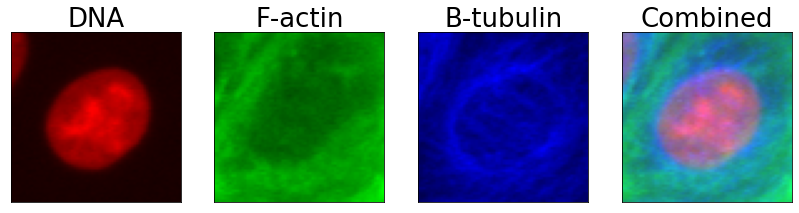

hello!


In [27]:
images[0]
plot_image_channels(img_saturate(images[0]))

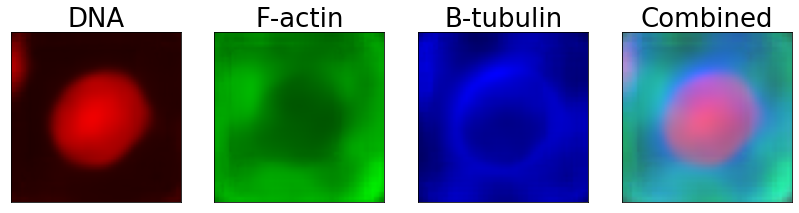

hello!


In [28]:
plot_image_channels(img_saturate(vae.observation_model(z[0:4]).mean.detach()[0]))